In [1]:
# Stacked GRU for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
export_dataframe_1 = pd.read_excel('export_dataframe.xlsx')

In [24]:
export_dataframe1=export_dataframe_1
export_dataframe=export_dataframe_1

In [25]:
#export_dataframe_2=export_dataframe_1[export_dataframe_1['Code Fournisseur']=='LACAISSESP'] 
export_dataframe=export_dataframe.groupby(pd.Grouper(key='Date Opération', axis=0, freq='D')).sum()
export_dataframe.head(3) 

,Dossier,Poids Taxable,Catégorie,Prévision,Réalisation,N° Achat,prev_resultat
Date Opération,,,,,,,
2017-01-02,1.862371e+10,720389.00,3367,10936.146190,10866.671905,2057463002,69.474286
2017-01-03,1.288171e+10,507856.00,1781,10097.422857,10090.737143,1259284920,6.685714
2017-01-04,2.608677e+10,1267171.63,4703,17320.157619,17306.176667,2839801236,13.980952


In [26]:
export_dataframe=export_dataframe['Réalisation'].to_frame()
export_dataframe=export_dataframe.reset_index()
export_dataframe.index=export_dataframe['Date Opération']
export_dataframe=export_dataframe.drop(['Date Opération'],1)

<ipython-input-26-829c8d3bab6b>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  export_dataframe=export_dataframe.drop(['Date Opération'],1)


In [27]:
export_dataframe.head()

,Réalisation
Date Opération,
2017-01-02,10866.671905
2017-01-03,10090.737143
2017-01-04,17306.176667
2017-01-05,38482.110952
2017-01-06,118472.743333


In [28]:
export_dataframe=export_dataframe.sort_values(by=['Date Opération'])

In [29]:

resultsDict = {}
predictionsDict = {}

split_date = '2020-12-31'

df_training = export_dataframe.loc[export_dataframe.index <= split_date]
df_test = export_dataframe.loc[export_dataframe.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

#df_training.to_csv('datasets/training.csv')
#df_test.to_csv('datasets/test.csv')
df_training.head(3)

1460 days of training data 
 448 days of testing data 


,Réalisation
Date Opération,
2017-01-02,10866.671905
2017-01-03,10090.737143
2017-01-04,17306.176667


In [30]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [31]:
from sklearn.preprocessing import StandardScaler
X_train_df, y_train = create_time_features(export_dataframe, target='Réalisation')
X_test_df, y_test = create_time_features(df_test, target='Réalisation')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

<ipython-input-30-b01fc2873f20>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-30-b01fc2873f20>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-30-b01fc2873f20>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-30-b01fc2873f20>:8: SettingWithCopyWarning: 
A value is trying to be set 

In [32]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)

In [33]:
# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

Test set equal: True


In [34]:
val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

In [35]:
simple_lstm_model.compile(optimizer='rmsprop', loss='mae')



EVALUATION_INTERVAL = 200
EPOCHS = 100

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support


Epoch 1/100
200/200 [==============================] - 8s 42ms/step - loss: 56007.7891 - val_loss: 60587.7188
Epoch 2/100
200/200 [==============================] - 6s 31ms/step - loss: 42778.3125 - val_loss: 53266.7344
Epoch 3/100
200/200 [==============================] - 8s 39ms/step - loss: 42677.1758 - val_loss: 53027.9883
Epoch 4/100
200/200 [==============================] - 6s 32ms/step - loss: 41575.3438 - val_loss: 51526.2344
Epoch 5/100
200/200 [==============================] - 7s 37ms/step - loss: 34532.8750 - val_loss: 42407.3555
Epoch 6/100
200/200 [==============================] - 7s 36ms/step - loss: 27222.8066 - val_loss: 36603.8281
Epoch 7/100
200/200 [==============================] - 6s 31ms/step - loss: 23807.5938 - val_loss: 42188.2383
Epoch 8/100
200/200 [==============================] - 7s 34ms/step - loss: 23889.4512 - val_loss: 31486.7207
Epoch 9/100
200/200 [==============================] - 6s 29ms/step - loss: 23444.9707 - val_loss: 31106.0527
Epoch 10/1

200/200 [==============================] - 7s 36ms/step - loss: 4349.3335 - val_loss: 8498.6445
Epoch 76/100
200/200 [==============================] - 7s 35ms/step - loss: 4189.4346 - val_loss: 7785.3882
Epoch 77/100
200/200 [==============================] - 6s 30ms/step - loss: 4249.2100 - val_loss: 7522.4531
Epoch 78/100
200/200 [==============================] - 8s 39ms/step - loss: 4212.8550 - val_loss: 8667.1914
Epoch 79/100
200/200 [==============================] - 6s 30ms/step - loss: 4023.3462 - val_loss: 7059.3638
Epoch 80/100
200/200 [==============================] - 8s 38ms/step - loss: 4030.3054 - val_loss: 7523.0723
Epoch 81/100
200/200 [==============================] - 7s 33ms/step - loss: 4046.0959 - val_loss: 8176.3970
Epoch 82/100
200/200 [==============================] - 7s 34ms/step - loss: 3839.4485 - val_loss: 7515.7549
Epoch 83/100
200/200 [==============================] - 8s 38ms/step - loss: 3894.7830 - val_loss: 8894.4453
Epoch 84/100
200/200 [==========

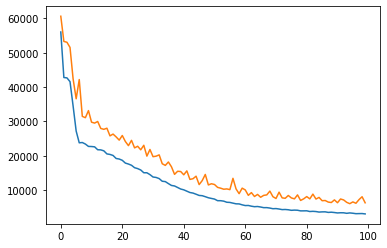

In [36]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model_history.history['loss']
val_loss=model_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)

In [37]:
import numpy as np
from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error

    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error

    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0

    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error

    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))


In [38]:
def predict_dates(num_prediction):
    last_date = export_dataframe.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast_dates = predict_dates(num_prediction)

In [39]:
df_future = pd.DataFrame(columns=['Date'])
df_future['Date'] = pd.date_range(start=export_dataframe.index.values[-1] +pd.Timedelta(days=1), periods=30)

In [40]:
df_future['Date']= pd.to_datetime(df_future['Date'])
df_future['hour'] = df_future['Date'].dt.hour
df_future['dayofweek'] = df_future['Date'].dt.dayofweek
df_future['quarter'] = df_future['Date'].dt.quarter
df_future['month'] = df_future['Date'].dt.month
df_future['year'] = df_future['Date'].dt.year
df_future['dayofyear'] = df_future['Date'].dt.dayofyear
df_future['sin_day'] = np.sin(df_future['dayofyear'])
df_future['cos_day'] = np.cos(df_future['dayofyear'])
df_future['dayofmonth'] = df_future['Date'].dt.day
df_future['weekofyear'] = df_future['Date'].dt.weekofyear
df_future = df_future.drop(['Date'], axis=1)

<ipython-input-40-d03e85de881d>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_future['weekofyear'] = df_future['Date'].dt.weekofyear


In [41]:
df_past_train = pd.DataFrame(columns=['Date'])
df_past_train['Date']= pd.to_datetime(export_dataframe.index)
df_past_train['hour'] = df_past_train['Date'].dt.hour
df_past_train['dayofweek'] = df_past_train['Date'].dt.dayofweek
df_past_train['quarter'] = df_past_train['Date'].dt.quarter
df_past_train['month'] = df_past_train['Date'].dt.month
df_past_train['year'] = df_past_train['Date'].dt.year
df_past_train['dayofyear'] = df_past_train['Date'].dt.dayofyear
df_past_train['sin_day'] = np.sin(df_past_train['dayofyear'])
df_past_train['cos_day'] = np.cos(df_past_train['dayofyear'])
df_past_train['dayofmonth'] = df_past_train['Date'].dt.day
df_past_train['weekofyear'] = df_past_train['Date'].dt.weekofyear
df_past_train = df_past_train.drop(['Date'], axis=1)

<ipython-input-41-c7c50079a539>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_past_train['weekofyear'] = df_past_train['Date'].dt.weekofyear


In [42]:
df_future = np.concatenate((df_past_train,df_future))

In [43]:
df_future.shape

(1938, 10)

In [44]:
scaler.fit(df_future)  # No cheating, never scale on the training+test!
df_future = scaler.transform(df_future)
def window_data_test(X, window):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
    return np.array(x)
df_future_test=window_data_test(df_future,24)


In [45]:
import math
math.floor(df_future_test.shape[0]/30)

63

In [71]:
df_future_test[-100:].shape

(30, 3)

In [48]:
def predict(num_prediction,model,lookback=0,pas=1):
    prediction_list = df_future_test[-(lookback+num_prediction):]
    look_forward=0
    future=[]
    for _ in range(num_prediction):
        x = prediction_list[look_forward:]
        out = simple_lstm_model.predict(x)[0][0]
        future.append(out)
        look_forward=look_forward+pas
        #prediction_list = np.append(prediction_list, out)
    return future
        
future1=predict(30, simple_lstm_model)
#future2=predict(30, simple_lstm_model,100)

In [49]:
df_past = export_dataframe[['Réalisation']].reset_index()
df_past.rename(columns={'index': 'Date Opération', 'Réalisation':'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(export_dataframe.index)
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

<ipython-input-49-9eea6b3a3daf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]


In [50]:
df_past

,Date Opération,Actual,Date,Forecast
0,2017-01-02,10866.671905,2017-01-02,NaN
1,2017-01-03,10090.737143,2017-01-03,NaN
2,2017-01-04,17306.176667,2017-01-04,NaN
3,2017-01-05,38482.110952,2017-01-05,NaN
4,2017-01-06,118472.743333,2017-01-06,NaN
...,...,...,...,...
1903,2022-03-20,0.000000,2022-03-20,NaN
1904,2022-03-21,2336.089524,2022-03-21,NaN
1905,2022-03-22,1774.378095,2022-03-22,NaN
1906,2022-03-23,3619.667619,2022-03-23,NaN


In [51]:
df_future_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future_test['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] +pd.Timedelta(days=1), periods=30)
df_future_test['Forecast'] = future1
df_future_test['Actual'] = np.nan

In [72]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    y = df_past.Actual,
    x = df_past.Date,
    mode = 'lines',
    name = 'Actual'
)
trace2 = go.Scatter(
    y= df_future_test.Forecast,
    x= df_future_test.Date,
    mode = 'lines',
    name = 'Prediction'
)

layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [69]:
from math import sqrt
true_value=df_past.Actual[-448:]
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]

rmse=sqrt(mean_squared_error(true_value,yhat))
rmse         

27934.71771586073

In [50]:
liste_foruni=list(export_dataframe['Code Fournisseur'].unique())
code_num=[i for i in range(len(liste_foruni))]

In [51]:
code={}
for id,cod in zip(liste_foruni,code_num):
    code[id]=cod

In [53]:
def get_id_fourni(cod):
    return code[cod]
export_dataframe['id_Fournisseur']=export_dataframe['Code Fournisseur'].apply(get_id_fourni,1)

In [55]:
cod=export_dataframe[export_dataframe['id_Fournisseur']==1]
cod

,Ligne,Dossier,Date Opération,Poids Taxable,Catégorie,Date présentation,Devise Prévision,Prévision,Devise Réalisation,Réalisation,N° Achat,Date Achat,Code Fournisseur,prev_resultat,cout_analys,id_Fournisseur
1,CMI,171300113.0,2017-01-02,86.0,11,2017-01-18 00:00:00,EUR,9.523810,EUR,9.523810,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1
1766,RIG,171000218.0,2017-01-07,226.0,11,2017-01-25 00:00:00,EUR,57.142857,EUR,57.142857,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1
1833,CMI,171300216.0,2017-01-09,278.0,11,2017-01-18 00:00:00,EUR,28.571429,EUR,28.571429,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1
2207,CMI,171300272.0,2017-01-12,584.0,11,2017-01-17 00:00:00,EUR,28.571429,EUR,28.571429,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1
2939,RIG,171000320.0,2017-01-13,3564.0,11,2017-01-20 00:00:00,EUR,28.571429,EUR,28.571429,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643607,NAT,221200418.0,2022-02-25,12401.0,11,2022-03-10 00:00:00,EUR,28.571429,EUR,0.000000,0,NaT,ZAOUIA GOLD T,28.571429,variance posi,1
643917,RIG,221002703.0,2022-02-25,37.0,11,2022-03-14 00:00:00,EUR,47.619048,EUR,0.000000,0,NaT,ZAOUIA GOLD T,47.619048,variance posi,1
645900,NAT,221200518.0,2022-03-01,17566.0,11,2022-03-05 00:00:00,EUR,57.142857,EUR,0.000000,0,NaT,ZAOUIA GOLD T,57.142857,variance posi,1
645959,CMI,221301321.0,2022-03-02,14000.0,11,2022-03-04 00:00:00,EUR,28.571429,EUR,0.000000,0,NaT,ZAOUIA GOLD T,28.571429,variance posi,1


In [62]:
export_dataframe=cod.groupby(pd.Grouper(key='Date Opération', axis=0, freq='W')).sum()
export_dataframe

,Dossier,Poids Taxable,Catégorie,Prévision,Réalisation,N° Achat,prev_resultat,id_Fournisseur
Date Opération,,,,,,,,
2017-01-08,3.423003e+08,312.00,22,66.666667,66.666667,34011526,0.000000,2
2017-01-15,1.027202e+09,5759.24,66,161.904762,161.904762,102034578,0.000000,6
2017-01-22,3.423010e+08,682.65,22,33.333333,33.333333,34011526,0.000000,2
2017-01-29,3.423015e+08,1469.50,22,57.142857,57.142857,34017021,0.000000,2
2017-02-05,6.843039e+08,1990.31,44,95.238095,95.238095,68045032,0.000000,4
...,...,...,...,...,...,...,...,...
2022-02-20,6.635036e+08,8773.00,33,133.333333,0.000000,0,133.333333,3
2022-02-27,1.105907e+09,13429.00,55,152.380952,0.000000,0,152.380952,5
2022-03-06,4.425018e+08,31566.00,22,85.714286,0.000000,0,85.714286,2


In [63]:
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


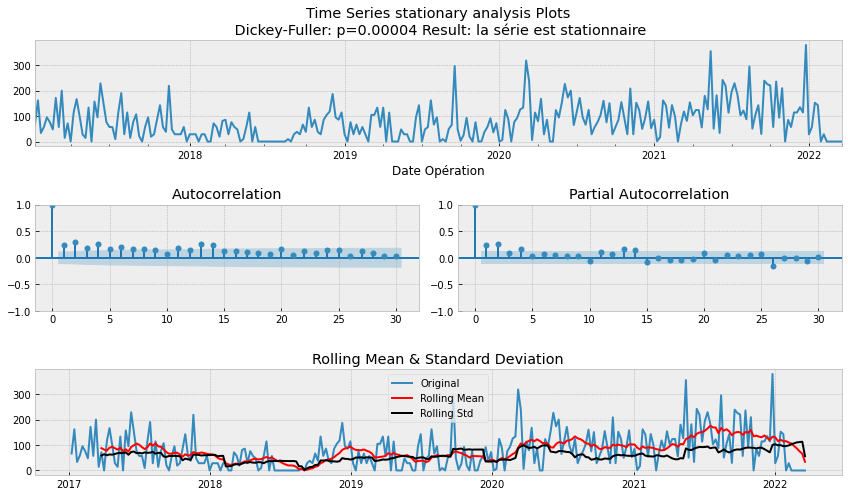

In [64]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "la série est stationnaire" if p_value <= 0.05 else "la série n'est stationnaire"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = export_dataframe.Réalisation.rolling(window=12).mean()
        rolstd = export_dataframe.Réalisation.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(export_dataframe.Réalisation, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(export_dataframe.Réalisation, lags=30)

# let's work with code fournisseur

In [325]:
liste_foruni=list(export_dataframe_1['Code Fournisseur'].unique())
code_num=[i for i in range(len(liste_foruni))]

In [326]:
code={}
for id,cod in zip(liste_foruni,code_num):
    code[id]=cod

In [38]:
code

{'OP_DIVERS_DEB': 0,
 'ZAOUIA GOLD T': 1,
 'LACAISSESP': 2,
 'DNECREDCASEXT': 3,
 'AOUNI TRANS': 4,
 'LACAISSEFP': 5,
 'CDGTIMAR': 6,
 'TIM_CASA': 7,
 'DNEREDEVINFO': 8,
 'PRO INTERIM': 9,
 'TRACTIONTANGE': 10,
 'TANGER MED PO': 11,
 'INTER SHIPPIN': 12,
 'TIM_TNG': 13,
 'LACAISSEVD': 14,
 'DOUANE CAS EX': 15,
 'TRANSBULL SP': 16,
 'FRS MAROC': 17,
 'NKR TRANS': 18,
 'FRIOFRISUR': 19,
 'MIGUEL & VILE': 20,
 'DFDS SEAWAYS': 21,
 'DELOM PORTU': 22,
 'JOEL LALAURIE': 23,
 'EVEREST TRANS': 24,
 'MARSA': 25,
 'CANET LEVAGE': 26,
 'MALIH ARCHI S': 27,
 'LOGIC TRANSPO': 28,
 'TR DOUANIERS': 29,
 'SOMAPORT': 30,
 'ATARI TRANS': 31,
 'COSMO SHIPPIN': 32,
 'DNECREDNOUAC': 33,
 'R.A.M -NDL': 34,
 'TRASMEDITERRA': 35,
 'R.A.M': 36,
 'LOCA EXPRESS': 37,
 'ROULERS TRANS': 38,
 'GOLDEN INTER': 39,
 'TIMAR INTL': 40,
 'PM TRANS': 41,
 'NHT TRANSPORT': 42,
 'ZARA TRANS': 43,
 'DNECREDTNG': 44,
 'EUROMAROC DET': 45,
 'SANER': 46,
 'BCR TRANSPORT': 47,
 'AT TRANS/LV': 48,
 'LOGITRANS ARI': 49,
 'GEMA': 5

In [327]:
def get_id_fourni(cod):
    return code[cod]
export_dataframe_1['id_Fournisseur']=export_dataframe_1['Code Fournisseur'].apply(get_id_fourni,1)

In [328]:
lignee=list(export_dataframe_1['Ligne'].unique())
code_numm=[i for i in range(len(lignee))]

In [329]:
co={}
for id,cod in zip(lignee,code_numm):
    co[id]=cod

In [330]:
def get_id_fourn(cod):
    return co[cod]
export_dataframe_1['New_Ligne']=export_dataframe_1['Ligne'].apply(get_id_fourn,1)

In [332]:
export_dataframe_1.head()

,Ligne,Dossier,Date Opération,Poids Taxable,Catégorie,Date présentation,Devise Prévision,Prévision,Devise Réalisation,Réalisation,N° Achat,Date Achat,Code Fournisseur,prev_resultat,cout_analys,id_Fournisseur,New_Ligne
0,CMI,171300113.0,2017-01-02,86.0,1,2017-01-16 00:00:00,EUR,44.571429,EUR,44.571429,17004515,2017-01-16,OP_DIVERS_DEB,0.0,invariance,0,0
1,CMI,171300113.0,2017-01-02,86.0,11,2017-01-18 00:00:00,EUR,9.523810,EUR,9.523810,17005763,2017-02-14,ZAOUIA GOLD T,0.0,invariance,1,0
2,CMI,171300114.0,2017-01-02,1488.0,1,2017-01-09 00:00:00,EUR,3.904762,EUR,3.904762,17001239,2017-01-10,LACAISSESP,0.0,invariance,2,0
3,CMI,171300115.0,2017-01-02,35.0,1,2017-01-05 00:00:00,EUR,208.476190,EUR,208.476190,17004707,2017-01-04,DNECREDCASEXT,0.0,invariance,3,0
4,CMI,171300119.0,2017-01-02,197.0,11,2017-01-03 00:00:00,EUR,16.701905,EUR,16.701905,17005562,2017-02-13,AOUNI TRANS,0.0,invariance,4,0


In [333]:
export_dataframe_2=export_dataframe_1.set_index(['Date Opération'])

In [334]:
export_dataframe_3=export_dataframe_1.set_index(['Date Opération'])


In [335]:
export_dataframe_2=export_dataframe_2.drop(['Ligne', 'Dossier', 'Poids Taxable', 'Date présentation',
       'Devise Prévision', 'Prévision', 'Devise Réalisation','N° Achat', 'Date Achat', 'Code Fournisseur', 
                                            'prev_resultat','cout_analys'],1)

<ipython-input-335-f43cac190dea>:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [336]:
export_dataframe_2

,Catégorie,Réalisation,id_Fournisseur,New_Ligne
Date Opération,,,,
2017-01-02,1,44.571429,0,0
2017-01-02,11,9.523810,1,0
2017-01-02,1,3.904762,2,0
2017-01-02,1,208.476190,3,0
2017-01-02,11,16.701905,4,0
...,...,...,...,...
2022-03-24,70,9.523810,14,32
2022-03-24,70,9.523810,14,32
2022-03-24,45,0.000000,40,64


In [337]:
split_date = '2021-12-31'

df_training = export_dataframe_2.loc[export_dataframe_2.index <= split_date]
df_test = export_dataframe_2.loc[export_dataframe_2.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

#df_training.to_csv('datasets/training.csv')
#df_test.to_csv('datasets/test.csv')
df_training.head(3)

620084 days of training data 
 32159 days of testing data 


,Catégorie,Réalisation,id_Fournisseur,New_Ligne
Date Opération,,,,
2017-01-02,1,44.571429,0,0
2017-01-02,11,9.523810,1,0
2017-01-02,1,3.904762,2,0


In [338]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y


In [339]:
from sklearn.preprocessing import StandardScaler
X_train_df, y_train = create_time_features(export_dataframe_2, target='Réalisation')
X_test_df, y_test = create_time_features(df_test, target='Réalisation')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)
X_test_df

<ipython-input-338-3d74ea191bd7>:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

<ipython-input-338-3d74ea191bd7>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-338-3d74ea191bd7>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-338-3d74ea191bd7>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,Catégorie,id_Fournisseur,New_Ligne,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
0,-0.484543,-0.466777,-0.709271,0.0,1.725932,-1.247921,-1.507044,1.826469,-1.622909,1.299091,-0.601142,-1.577832,1.705944
1,-0.484543,-0.466777,-0.709271,0.0,1.725932,-1.247921,-1.507044,1.826469,-1.622909,1.299091,-0.601142,-1.577832,1.705944
2,-0.484543,-0.466777,-0.709271,0.0,1.725932,-1.247921,-1.507044,1.826469,-1.622909,1.299091,-0.601142,-1.577832,1.705944
3,-0.484543,-0.466777,-0.709271,0.0,1.725932,-1.247921,-1.507044,1.826469,-1.622909,1.299091,-0.601142,-1.577832,1.705944
4,-0.484543,-0.466777,-0.709271,0.0,1.725932,-1.247921,-1.507044,1.826469,-1.622909,1.299091,-0.601142,-1.577832,1.705944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32154,1.446044,-0.389764,1.729627,0.0,-0.235495,-1.247921,-0.941901,1.826469,-0.873192,1.383092,0.335232,0.945932,-0.882698
32155,1.446044,-0.389764,1.729627,0.0,-0.235495,-1.247921,-0.941901,1.826469,-0.873192,1.383092,0.335232,0.945932,-0.882698
32156,0.440530,-0.167283,4.420824,0.0,-0.235495,-1.247921,-0.941901,1.826469,-0.873192,1.383092,0.335232,0.945932,-0.882698
32157,-1.329175,-0.509562,4.252624,0.0,-0.235495,-1.247921,-0.941901,1.826469,-0.873192,1.383092,0.335232,0.945932,-0.882698


In [313]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)

In [314]:
# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

Test set equal: True


In [315]:
val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

In [316]:
simple_lstm_model.compile(optimizer='rmsprop', loss='mae')



EVALUATION_INTERVAL = 200
EPOCHS = 200

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=95)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support


Epoch 1/200
200/200 [==============================] - 7s 33ms/step - loss: 169.8072 - val_loss: 188.6237
Epoch 2/200
200/200 [==============================] - 6s 29ms/step - loss: 178.7244 - val_loss: 188.5571
Epoch 3/200
200/200 [==============================] - 6s 29ms/step - loss: 188.2589 - val_loss: 190.7532
Epoch 4/200
200/200 [==============================] - 6s 31ms/step - loss: 180.2906 - val_loss: 192.6949
Epoch 5/200
200/200 [==============================] - 6s 30ms/step - loss: 178.6189 - val_loss: 192.1317
Epoch 6/200
200/200 [==============================] - 6s 30ms/step - loss: 209.9548 - val_loss: 197.5269
Epoch 7/200
200/200 [==============================] - 7s 34ms/step - loss: 196.9420 - val_loss: 201.3642
Epoch 8/200
200/200 [==============================] - 7s 35ms/step - loss: 183.4743 - val_loss: 235.4100
Epoch 9/200
200/200 [==============================] - 7s 35ms/step - loss: 202.9903 - val_loss: 275.0902
Epoch 10/200
200/200 [========================

Epoch 77/200
200/200 [==============================] - 27s 137ms/step - loss: 171.2793 - val_loss: 180.1685
Epoch 78/200
200/200 [==============================] - 28s 139ms/step - loss: 143.4383 - val_loss: 181.3319
Epoch 79/200
200/200 [==============================] - 27s 135ms/step - loss: 149.9003 - val_loss: 183.3466
Epoch 80/200
200/200 [==============================] - 28s 139ms/step - loss: 153.7634 - val_loss: 174.3327
Epoch 81/200
200/200 [==============================] - 28s 138ms/step - loss: 163.5937 - val_loss: 163.5057
Epoch 82/200
200/200 [==============================] - 28s 139ms/step - loss: 157.3995 - val_loss: 165.6520
Epoch 83/200
200/200 [==============================] - 27s 135ms/step - loss: 188.6469 - val_loss: 164.5186
Epoch 84/200
200/200 [==============================] - 29s 147ms/step - loss: 158.0057 - val_loss: 170.0522
Epoch 85/200
200/200 [==============================] - 27s 137ms/step - loss: 137.4664 - val_loss: 173.3401
Epoch 86/200
200/20

In [319]:
simple_lstm_model.save('model_ligne_categorie.h5')

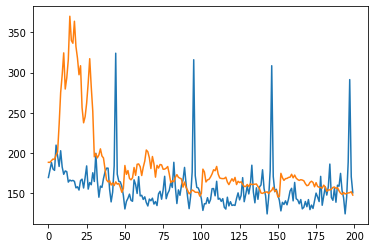

In [340]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model_history.history['loss']
val_loss=model_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)

In [341]:
def predict_dates(num_prediction):
    last_date = export_dataframe.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates
num_prediction = 300
forecast_dates = predict_dates(num_prediction)
rmse=sqrt(mean_squared_error(y_test, forecast_dates)

In [342]:
df_future = pd.DataFrame(columns=['Date'])
df_future['Date'] = pd.date_range(start=export_dataframe.index.values[-1] + pd.Timedelta(days=1), periods=num_prediction)

In [343]:
df_future['Date']= pd.to_datetime(df_future['Date'])
df_future['hour'] = df_future['Date'].dt.hour
df_future['dayofweek'] = df_future['Date'].dt.dayofweek
df_future['quarter'] = df_future['Date'].dt.quarter
df_future['month'] = df_future['Date'].dt.month
df_future['year'] = df_future['Date'].dt.year
df_future['dayofyear'] = df_future['Date'].dt.dayofyear
df_future['sin_day'] = np.sin(df_future['dayofyear'])
df_future['cos_day'] = np.cos(df_future['dayofyear'])
df_future['dayofmonth'] = df_future['Date'].dt.day
df_future['weekofyear'] = df_future['Date'].dt.weekofyear
df_future['id_Fournisseur']=1
df_future['New_Ligne']= co['CMI']
df_future['Catégorie']= 11
df_future = df_future.drop(['Date'], axis=1)

<ipython-input-343-b842cc042a6f>:11: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [344]:
export_dataframe_2

,Catégorie,Réalisation,id_Fournisseur,New_Ligne,date,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
Date Opération,,,,,,,,,,,,,,,
2017-01-02,1,44.571429,0,0,2017-01-02,0,0,1,1,2017,2,0.909297,-0.416147,2,1
2017-01-02,11,9.523810,1,0,2017-01-02,0,0,1,1,2017,2,0.909297,-0.416147,2,1
2017-01-02,1,3.904762,2,0,2017-01-02,0,0,1,1,2017,2,0.909297,-0.416147,2,1
2017-01-02,1,208.476190,3,0,2017-01-02,0,0,1,1,2017,2,0.909297,-0.416147,2,1
2017-01-02,11,16.701905,4,0,2017-01-02,0,0,1,1,2017,2,0.909297,-0.416147,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24,70,9.523810,14,32,2022-03-24,0,3,1,3,2022,83,0.968364,0.249540,24,12
2022-03-24,70,9.523810,14,32,2022-03-24,0,3,1,3,2022,83,0.968364,0.249540,24,12
2022-03-24,45,0.000000,40,64,2022-03-24,0,3,1,3,2022,83,0.968364,0.249540,24,12


In [345]:
export_dataframe_2=export_dataframe_2.drop(['Réalisation','date'],1)
export_dataframe_2=export_dataframe_2.reset_index(drop=True)

<ipython-input-345-f029b309f64a>:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [346]:
export_dataframe_2.head(3)

,Catégorie,id_Fournisseur,New_Ligne,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
0,1,0,0,0,0,1,1,2017,2,0.909297,-0.416147,2,1
1,11,1,0,0,0,1,1,2017,2,0.909297,-0.416147,2,1
2,1,2,0,0,0,1,1,2017,2,0.909297,-0.416147,2,1


In [347]:
export_dataframe_2=export_dataframe_2[(export_dataframe_2['id_Fournisseur']==code['LACAISSESP']) & (export_dataframe_2['New_Ligne']==1) & (export_dataframe_2['Catégorie']==11)]


In [348]:
df_future.head(3)

,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear,id_Fournisseur,New_Ligne,Catégorie
0,0,4,1,3,2022,84,0.733190,-0.680023,25,12,1,0,11
1,0,5,1,3,2022,85,-0.176076,-0.984377,26,12,1,0,11
2,0,6,1,3,2022,86,-0.923458,-0.383698,27,12,1,0,11


In [355]:
df_past_train = pd.DataFrame(columns=['Date'])
df_past_train['Date']= pd.to_datetime(export_dataframe_2.index)
df_past_train['id_Fournisseur']= export_dataframe_2.id_Fournisseur
df_past_train['New_Ligne']= export_dataframe_2.New_Ligne
df_past_train['Catégorie']= export_dataframe_2.Catégorie
df_past_train['hour'] = df_past_train['Date'].dt.hour
df_past_train['dayofweek'] = df_past_train['Date'].dt.dayofweek
df_past_train['quarter'] = df_past_train['Date'].dt.quarter
df_past_train['month'] = df_past_train['Date'].dt.month
df_past_train['year'] = df_past_train['Date'].dt.year
df_past_train['dayofyear'] = df_past_train['Date'].dt.dayofyear
df_past_train['sin_day'] = np.sin(df_past_train['dayofyear'])
df_past_train['cos_day'] = np.cos(df_past_train['dayofyear'])
df_past_train['dayofmonth'] = df_past_train['Date'].dt.day
df_past_train['weekofyear'] = df_past_train['Date'].dt.weekofyear
df_past_train = df_past_train.drop(['Date'], axis=1)


<ipython-input-355-d198f7d924ce>:15: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [295]:
#frames = []

#result = pd.concat(frames)
df_future = np.concatenate((export_dataframe_2,df_future))

In [296]:
scaler.fit(df_future)  # No cheating, never scale on the training+test!
df_future = scaler.transform(df_future)
def window_data_test(X, window):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
    return np.array(x)
df_future_test=window_data_test(df_future,24)

In [297]:
df_future_test.shape[0]

277

In [298]:
def predict(num_prediction,model,lookback=0,pas=1):
    
    prediction_list = df_future_test[-(lookback+num_prediction):]
    look_forward=0
    future=[]
    for _ in range(num_prediction):
        x = prediction_list[look_forward:]
        print(x.shape)
        out = model.predict(x)[0][0]
        future.append(out)
        look_forward=look_forward+pas
        #prediction_list = np.append(prediction_list, out)
    return future
        
#future1=predict(num_prediction, simple_lstm_model)
future2=predict(df_future_test.shape[0], simple_lstm_model,500)

(277, 24, 13)
(276, 24, 13)
(275, 24, 13)
(274, 24, 13)
(273, 24, 13)
(272, 24, 13)
(271, 24, 13)
(270, 24, 13)
(269, 24, 13)
(268, 24, 13)
(267, 24, 13)
(266, 24, 13)
(265, 24, 13)
(264, 24, 13)
(263, 24, 13)
(262, 24, 13)
(261, 24, 13)
(260, 24, 13)
(259, 24, 13)
(258, 24, 13)
(257, 24, 13)
(256, 24, 13)
(255, 24, 13)
(254, 24, 13)
(253, 24, 13)
(252, 24, 13)
(251, 24, 13)
(250, 24, 13)
(249, 24, 13)
(248, 24, 13)
(247, 24, 13)
(246, 24, 13)
(245, 24, 13)
(244, 24, 13)
(243, 24, 13)
(242, 24, 13)
(241, 24, 13)
(240, 24, 13)
(239, 24, 13)
(238, 24, 13)
(237, 24, 13)
(236, 24, 13)
(235, 24, 13)
(234, 24, 13)
(233, 24, 13)
(232, 24, 13)
(231, 24, 13)
(230, 24, 13)
(229, 24, 13)
(228, 24, 13)
(227, 24, 13)
(226, 24, 13)
(225, 24, 13)
(224, 24, 13)
(223, 24, 13)
(222, 24, 13)
(221, 24, 13)
(220, 24, 13)
(219, 24, 13)
(218, 24, 13)
(217, 24, 13)
(216, 24, 13)
(215, 24, 13)
(214, 24, 13)
(213, 24, 13)
(212, 24, 13)
(211, 24, 13)
(210, 24, 13)
(209, 24, 13)
(208, 24, 13)
(207, 24, 13)
(206, 

In [299]:
export_dataframe_3=export_dataframe_3[(export_dataframe_3['id_Fournisseur']==1) & (export_dataframe_3['New_Ligne']==co['CMI']) & (export_dataframe_3['Catégorie']==11)]
export_dataframe_3

,Ligne,Dossier,Poids Taxable,Catégorie,Date présentation,Devise Prévision,Prévision,Devise Réalisation,Réalisation,N° Achat,Date Achat,Code Fournisseur,prev_resultat,cout_analys,id_Fournisseur,New_Ligne
Date Opération,,,,,,,,,,,,,,,,
2017-01-02,CMI,171300113.0,86.00,11,2017-01-18 00:00:00,EUR,9.523810,EUR,9.523810,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1,0
2017-01-09,CMI,171300216.0,278.00,11,2017-01-18 00:00:00,EUR,28.571429,EUR,28.571429,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1,0
2017-01-12,CMI,171300272.0,584.00,11,2017-01-17 00:00:00,EUR,28.571429,EUR,28.571429,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1,0
2017-01-14,CMI,171300341.0,163.00,11,2017-01-20 00:00:00,EUR,19.323810,EUR,19.323810,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1,0
2017-01-14,CMI,171300345.0,1092.24,11,2017-01-18 00:00:00,EUR,47.619048,EUR,47.619048,17005763,2017-02-14,ZAOUIA GOLD T,0.000000,invariance,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-09,CMI,221300806.0,223.00,11,2022-02-21 00:00:00,EUR,22.356190,EUR,0.000000,0,NaT,ZAOUIA GOLD T,22.356190,variance posi,1,0
2022-02-15,CMI,221300952.0,7000.00,11,2022-02-17 00:00:00,EUR,28.571429,EUR,0.000000,0,NaT,ZAOUIA GOLD T,28.571429,variance posi,1,0
2022-02-21,CMI,221301101.0,88.00,11,2022-03-07 00:00:00,EUR,47.619048,EUR,0.000000,0,NaT,ZAOUIA GOLD T,47.619048,variance posi,1,0


In [300]:
df_past = export_dataframe_3[['Réalisation']].reset_index()
df_past.rename(columns={'index': 'Date Opération', 'Réalisation':'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(export_dataframe_3.index)
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

<ipython-input-300-2d9647827a71>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [301]:
df_past['Date'].iloc[-1]

Timestamp('2022-03-18 00:00:00')

In [302]:
df_future_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future_test['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] +pd.Timedelta(days=1), periods=int(df_future_test.shape[0]))
df_future_test['Forecast'] = future2
df_future_test['Actual'] = np.nan

In [303]:
df_future_test['Date']=pd.date_range(start=df_past['Date'].iloc[-1] +pd.Timedelta(days=1), periods=int(df_future_test.shape[0])).tolist()

In [304]:
print(df_future_test.Forecast)
df_future_test['Date']

0     -27.884850
1      22.095739
2     -17.284115
3      -1.853855
4       8.019888
         ...    
272   -71.430695
273   -88.195854
274    28.128119
275   -27.058540
276   -39.380726
Name: Forecast, Length: 277, dtype: float32


0     2022-03-19
1     2022-03-20
2     2022-03-21
3     2022-03-22
4     2022-03-23
         ...    
272   2022-12-16
273   2022-12-17
274   2022-12-18
275   2022-12-19
276   2022-12-20
Name: Date, Length: 277, dtype: datetime64[ns]

In [305]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    y = df_past.Actual,
    x= df_past.Date,
    mode = 'lines',
    name = 'Actual'
)
trace2 = go.Scatter(
    y = df_future_test.Forecast,
    x = df_future_test.Date,
    mode = 'lines',
    name = 'Prediction'
)

layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [86]:
from keras.models import load_model
simple_lstm_model= load_model('my_model_supliers.h5')